In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [11]:
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler


In [12]:
def compute_class_weights(y, num_classes, method='balanced'):
    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y)
    elif method == 'inverse':
        class_counts = np.bincount(y)
        weights = 1. / (class_counts + 1e-5)
    else:
        weights = np.ones(num_classes)
    return torch.tensor(weights, dtype=torch.float32)


In [13]:
def create_dataloaders(X, y, test_size=0.2, val_size=0.1, batch_size=128):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), stratify=y_train_val)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)), batch_size=batch_size)
    return train_loader, val_loader, test_loader


In [14]:
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout_rates=[0.5, 0.4, 0.3], activation='leakyrelu', num_classes=6, use_batchnorm=True):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h, d in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev_dim, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU(0.1))
            elif activation == 'gelu':
                layers.append(nn.GELU())
            layers.append(nn.Dropout(d))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce)
        return ((1 - pt) ** self.gamma * ce).mean()


In [16]:
def train_mlp_model(train_loader, val_loader, input_dim, num_classes, hidden_dims, dropout_rates, activation, use_batchnorm, lr, weight_decay, epochs=150):
    model = CowHealthMLP(input_dim, hidden_dims, dropout_rates, activation, num_classes, use_batchnorm)
    all_labels = [label.item() for _, labels in train_loader for label in labels]
    class_weights = compute_class_weights(np.array(all_labels), num_classes)
    criterion = FocalLoss(alpha=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_model = None
    best_val_loss = float('inf')
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    no_improve = 0

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x.size(0)
        train_loss_hist.append(epoch_loss / len(train_loader.dataset))

        model.eval()
        preds, true = [], []
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                out = model(x) / 2.0  # 🔥 temperature scaling
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)
                preds += out.argmax(1).cpu().tolist()
                true += y.cpu().tolist()
        val_loss /= len(val_loader.dataset)
        val_f1 = f1_score(true, preds, average='weighted')
        val_loss_hist.append(val_loss)
        val_f1_hist.append(val_f1)
        scheduler.step(val_loss)

        if val_loss < best_val_loss - 0.001:
            best_val_loss = val_loss
            best_model = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= 10:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model)
    return model, train_loss_hist, val_loss_hist, val_f1_hist


In [17]:
def evaluate_model(model, test_loader, label_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            out = model(x) / 2.0  # temperature scaling
            all_preds += out.argmax(1).cpu().tolist()
            all_labels += y.cpu().tolist()

    print(classification_report(all_labels, all_preds, target_names=label_names))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Blues')
    plt.title("Normalized Confusion Matrix")
    plt.show()


 63%|██████▎   | 94/150 [39:36<23:35, 25.28s/it]   

Early stopping at epoch 95


               precision    recall  f1-score   support

      oestrus       0.83      0.89      0.86      3599
      calving       0.99      1.00      0.99      3731
     lameness       0.97      1.00      0.98      3729
     mastitis       0.97      1.00      0.99      3727
other_disease       0.96      1.00      0.98      3713
           OK       0.87      0.68      0.76      3208

     accuracy                           0.94     21707
    macro avg       0.93      0.93      0.93     21707
 weighted avg       0.93      0.94      0.93     21707



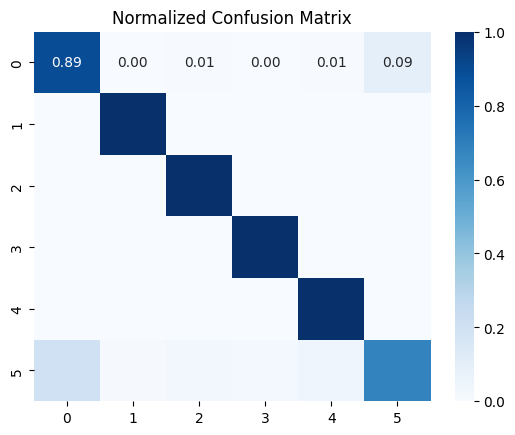

In [18]:
df = pd.read_csv("C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv")
label_cols = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
drop_cols = ['cow', 'duration_hours']
X, y, scaler = preprocess_dataset(df, label_cols, drop_cols)
train_loader, val_loader, test_loader = create_dataloaders(X, y)

model, _, _, _ = train_mlp_model(
    train_loader, val_loader,
    input_dim=X.shape[1],
    num_classes=len(label_cols),
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=150
)

evaluate_model(model, test_loader, label_names=label_cols)
